Jean-Louis DU / 28706249 \
Wassim TAHER / 28705837

# <font color = "steelblue"> Laplace tronquée </font>

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.special import kn
rng = default_rng()

## <font color = "orange"> Générer et évaluer des distributions de Laplace </font>

Dans cette partie on a essayer de reproduire le travail précédemment fait sur la distribution Gaussienne. On va aussi s'intéresser à la troncature sur les composantes positives.

Pour commencer, on a que la densité d'une Laplace en dimension 1 de paramètre de position $\mu$ et de paramètre d'échelle $\sigma$ (strictement positif) s'écrit comme ceci :

$$\phi(\mathbf{x} | \mathbf{\mu}, \sigma) = \frac{1}{2\sigma} \exp\left(-\frac{\lvert \mathbf{x} - \mu \rvert}{\sigma}\right)
$$

In [4]:
def f1(x,mu1, sig1):
    """ Densité de la loi laplace de moyenne mu1 et de variance sig1 """
    return laplace.pdf(x, loc=mu1, scale=sig1)

En dimension n, le problème est plus compliqué, on a essayé de créer une fonction permettant d'évaluer cette densité, mais en vain. même si l'on avait réussi à évaluer cette densité, on aurait toujours le problème de savoir générer selon cette densité. 

````
def fnbis(x, mun, sign):
    """ mun : Rn
        sign : Rnxn
    """
    n = len(mun)
    mat_inv = np.linalg.inv(sign)
    stock = x@mat_inv@x
    stock2 = mun@mat_inv@mun
    comp1 = (2*np.exp(x@mat_inv@mun))/((2*np.pi)**(n/2)*np.linalg.det(mat_sign)**0.5)
    comp2 = (stock/(2+stock2))**((2-n)/4)
    comp4 = np.sqrt((2+stock2)*stock)
    # (2-n)/2 n'est pas toujours un entier
    comp3 = kn(int((2-n)/2), comp4)
    return comp1*comp2*comp3
````

On s'est donc limité au cas où chaque dimension est indépendante des autres, c'est à dire que la matrice $\Sigma$ est diagonale, on peut juste se donner $\sigma$ comportant les éléments de la diagonale. 
Dans ce cas là, la densité jointe de la laplace en dimension n est le produit de n densités marginales.
$$\phi_n(\mathbf{x} | \mathbf{\mu}, \sigma) = \prod_{i=1}^{n} \phi (\mathbf{x}_i | \mathbf{\mu}_i, \sigma_i)
$$
On peut ainsi la générer à l'aide de plusieurs laplace 1D indépendantes.

In [5]:
def fn(x, mun, sign):
    """ Densité de la laplace en dimension n pour une covariance diagonale
    x, mean, scale de taille Rn """
    res = 1
    for i in range(len(x)):
        res *= laplace.pdf(x[i], loc=mun[i], scale=sign[i])
    return res

def multivariate_laplace(mean, scale, size=1):
    # Générer des échantillons aléatoires pour chaque dimension
    samples = np.random.laplace(loc=mean, scale=scale, size=(size, len(mean)))
    return samples

## <font color = "orange"> Trouver la constante de renomarlisation </font>

Lors de la méthode de rejet on aura besoin de savoir évaluer la densité tronquée en un point, on va donc chercher à l'exprimer explicitement.

Puisque que l'on considère que chaque dimension est indépendantes des autres, il nous suffit de travailler sur le cas 1D.

$$f(\mathbf{x} | \mathbf{\mu}, \sigma) = \frac{\phi(\mathbf{x} | \mathbf{\mu}, \sigma)}{C}\mathbb{1}_{\mathbb{R}_+}(\mathbf{x})
$$

Avec C une constante de renormalisation de sorte à ce que $f$ soit une densité.

En passant à l'intégrale sur $\mathbb{R}$ et en constatant que $f$ défini une densité,  on obtient 
$$ C = \int_{\mathbb{R}_+} \phi(\mathbf{x}) d\mathbf{x} $$

Or on ne sait pas calculer cette quantité explicitement, on va donc utiliser un Monte-Carlo avec de l'importance sampling afin de calculer cette constante de renormalisation.

$$ \int_{\mathbb{R}_+} \phi(\mathbf{x}) d\mathbf{x} = \int \mathbb{1}_{\mathbb{R}_+}(\mathbf{x}) \phi(\mathbf{x}) d\mathbf{x} $$
$$ = \int \mathbb{1}_{\mathbb{R}_+}(\mathbf{x}) \frac{\phi(\mathbf{x})}{\phi_{\theta}(\mathbf{x})} \phi_{\theta}(\mathbf{x}) d\mathbf{x}$$ avec $\phi_{\theta}(\mathbf{x} | \mathbf{\mu}, \sigma) = \frac{1}{2\sigma} \exp\left(-\frac{\lvert \mathbf{x} - \mu - \theta \rvert}{\sigma}\right)$
$$ = \mathbb{E}_{\theta}\left[\mathbb{1}_{\mathbb{R}_+}(\mathbf{x}) \frac{\phi(\mathbf{x})}{\phi_{\theta}(\mathbf{x})} \right]$$
$$ = \mathbb{E}_{\theta}\left[\mathbb{1}_{\mathbb{R}_+}(\mathbf{x}) \exp\left( \frac{\lvert \mathbf{x} - \mu - \theta \rvert - \lvert \mathbf{x} - \mu \rvert}{\sigma}\right)\right]$$


On choisi $\theta = max(-\mu, 0)$ de sorte à ce que la probabilité soit meilleure que l'estimateur classique. 

Pour le cas en dimension de n, il suffit d'appliquer cet estimateur sur chaque composante (en effet le coût va s'avérer de plus en plus cher).

In [6]:
def mc1(mu1, sig1, size = 10000):
    mu1_bis = max(mu1, 0)
    teta = max(-mu1, 0)
    sample = np.random.laplace(loc = mu1_bis, scale = sig1, size = size)
    res1 = sample>0
    res2 = np.exp((np.abs(sample-mu1-teta)-np.abs(sample-mu1))/sig1)
    return np.mean(res1*res2)

def mcn(mun, sign, size = 10000):
    """ Faire un mc1 sur chaque dimension puis faire le produit """
    res = 1
    for i in range(len(mun)):
        res *= mc1(mun[i], sign[i])
    return res

def f_tronc1(x, mu1, sig1, c1):
    """ En dimension 1 dans notre étude on tronque la partie négative """
    if x < 0:
        return 0
    else :
        return f1(x, mu1, sig1)/c1

def f_troncn(x, mun, sign, cn):
    """ En dimension n dans notre étude on garde (R+)^n """
    # Si x à une composante négative sa densité est nulle puisque que l'on tronque quand c'est négatif
    if np.any(x < 0):
        return 0
    else :
        # On additionne un nombre infiniment petit car dans certains cas le cn vaut 0 car tout les mus générés aléatoirement comporte au moins une composante négative
        return fn(x, mun, sign)/(cn+ 1e-100)

## <font color = "orange"> Choisir g et déterminer le taux d'acceptation </font>

Maintenant on sait évaluer la loi tronquée.
La prochaine question à se poser est quelle est le choix de g ? \
On rappelle que l'on veut g une densité tel que $$\exists D > 0  \quad \text{tq } \quad f(\mathbf{x}) \le Dg(\mathbf{x})$$ \
Le taux d'acceptation vaut $1/D$.

Un g qui convient est $\widetilde{g} = \phi_n(\mathbf{x} | \mathbf{\mu}, \sigma) $, cela nous donne $\widetilde{D} = 1/C $. Généralement le taux d'acceptation obtenu à partir de celà n'est pas très bon. On va donc chercher à trouver de meilleures fonctions g.

En dimension 1 \
On peut prendre g une gaussienne de même variance et de moyenne $\mu = \max(\mu, 0)$. \
Ainsi si $\mu \geq 0 \quad \text{alors} \quad D = 1/C$ \
et si $\mu \leq 0 \quad \text{alors} \quad\frac{f}{g}(\mathbf{x}) = \frac{1}{C}\exp\left(\frac{-\lvert \mathbf{x}-\mu \rvert + \lvert \mathbf{x} \rvert}{\sigma}\right)\mathbb{1}_{\mathbb{R}^+}(x) \leq \frac{1}{C}\exp(\frac{\mu}{\sigma}) = D$

En dimension n, il suffit de choisir $\mu_i = \max(\mu_i, 0) \quad \forall i \quad$ et pour chaque i on obtient ainsi $D_i$, puis pour obtenir D on fait le produit des $D_i$.

In [7]:
def trouver_d1(mu1, sig1, c1):
    """ Renvoie D tel que f <= Dg
        Trouve l'inverse du taux d'acceptation """
    mu1_t = max(0,mu1)
    return np.exp((mu1-mu1_t)/sig1)/c1

def g1_d(x, mu1, sig1, d1):
    """ On regarde la valeur de mu1 """
    mu1_t = max(0,mu1)
    return f1(x, mu1_t, sig1)*d1

def trouver_dn(mun, sign, cn):
    """ Renvoie D tel que f <= Dg
        Trouve l'inverse du taux d'acceptation """
    mun_t = np.maximum(mun, 0)
    res = 1
    for i in range(len(mun)):
        # On met 1 parce que on veut compter la constante de renormalisation qu'une seule fois
        res *= trouver_d1(mun[i], sign[i], 1)
    return res/cn

# <font color="steelblue">Exemple et représentation en dimension 1</font>

Taux d'acceptations :    0.9307  ///  0.5052


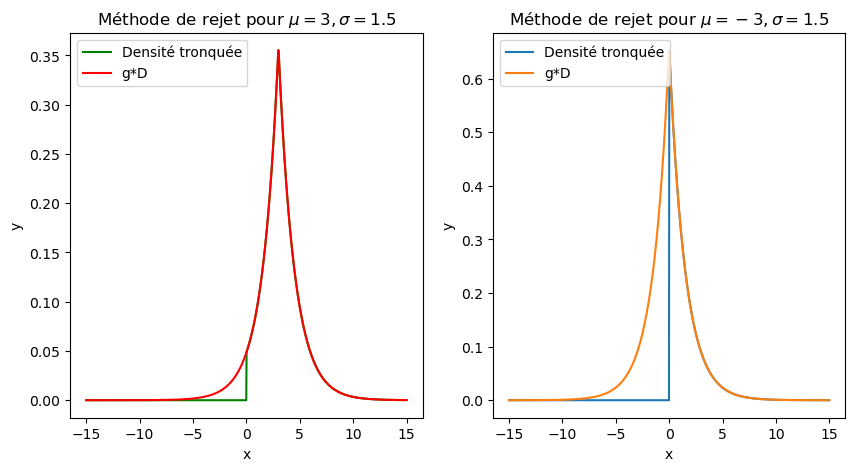

In [15]:
# Data test
m1 = -3
m1_bis = 3
s1 = 1.5

const_1 = mc1(m1, s1)
const_1bis = mc1(m1_bis, s1)

d1 = trouver_d1(m1, s1, const_1)
d1bis = trouver_d1(m1_bis, s1, const_1bis)

x = np.linspace(-15,15,1000)

print("Taux d'acceptations :   ", 1/d1bis, " /// ", 1/d1)

y1 = [f_tronc1(i, m1_bis, s1, const_1bis) for i in x]
y2 = [g1_d(i, m1_bis, s1, d1bis) for i in x]
y3 = [f_tronc1(i, m1, s1, const_1) for i in x]
y4 = [g1_d(i, m1, s1, d1) for i in x]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

ax1.plot(x,y1, label="Densité tronquée", color = "green")
ax1.plot(x,y2, label="g*D", color = "red")
ax1.legend()
ax1.set_title(rf"Méthode de rejet pour $\mu = {m1_bis}, \sigma = {s1}$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(x,y3, label="Densité tronquée")
ax2.plot(x,y4, label="g*D")
ax2.legend()
ax2.set_title(rf"Méthode de rejet pour $\mu = {m1}, \sigma = {s1}$")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()

# <font color = "steelblue"> Evolution du pourcentage de rejet en fonction de la dimension

In [16]:
def fonction_ultime_gauss(n, size = 100):
    """ On lui donne juste la dimension n 
        Cas où les covariances sont diagonales """
    if n == 1:
        mus = rng.uniform(-5, 5, size = size)
        sigmas = rng.uniform(1,5, size = size)
        c = [mc1(mus[i], sigmas[i]) for i in range(size)]
        d = [trouver_d1(mus[i], sigmas[i], c[i]) for i in range(size)]
        taux = np.mean(1/np.array(d))
        print("Dimension : ",n, " -> Taux d'acceptation : ", taux)
        return taux
        
    elif n>1 :
        idn = np.eye(n)
        mus = rng.uniform(-5,5, size = (size,n))
        sigmas = rng.uniform(1,5,size = (size, n))
        c = [mcn(mus[i], sigmas[i]) for i in range(size)]
        d = [trouver_dn(mus[i], sigmas[i], c[i]) for i in range(size)]
        taux = np.mean(1/np.array(d))
        print("Dimension : ",n, " -> Taux d'acceptation : ", taux)
        return taux

Dimension :  1  -> Taux d'acceptation :  0.598801
Dimension :  2  -> Taux d'acceptation :  0.40217515840000007
Dimension :  3  -> Taux d'acceptation :  0.25367090669014997
Dimension :  4  -> Taux d'acceptation :  0.16252093382109634
Dimension :  5  -> Taux d'acceptation :  0.10528734942950009
Dimension :  6  -> Taux d'acceptation :  0.06566219276304133
Dimension :  7  -> Taux d'acceptation :  0.048319592860947835
Dimension :  8  -> Taux d'acceptation :  0.025259413658862986
Dimension :  9  -> Taux d'acceptation :  0.016839118396329324
Dimension :  10  -> Taux d'acceptation :  0.010259763310523345
Dimension :  11  -> Taux d'acceptation :  0.005315970007916461
Dimension :  12  -> Taux d'acceptation :  0.0043838350076107115
Dimension :  13  -> Taux d'acceptation :  0.0022732071855023277
Dimension :  14  -> Taux d'acceptation :  0.0020091370104895387
Dimension :  15  -> Taux d'acceptation :  0.0011661436043344422
Dimension :  16  -> Taux d'acceptation :  0.0008262529791900638
Dimension :  

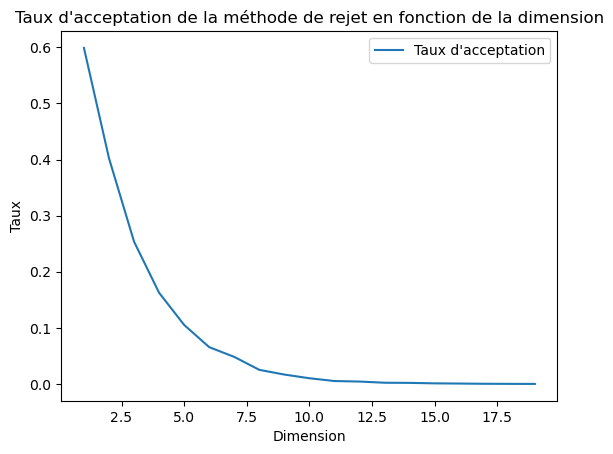

In [19]:
# Plot
list_dim = np.arange(1, 20)
taux_dim = [fonction_ultime_gauss(i) for i in list_dim]

plt.plot(list_dim, taux_dim, label = "Taux d'acceptation")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Taux")
plt.title("Taux d'acceptation de la méthode de rejet en fonction de la dimension")
plt.show()

Comme pour les gaussiennes on remarque que plus la dimension est grande plus la méthode de rejet est inefficace.

# <font color = "darkviolet"> Conclusion : L'efficacité de la méthode de rejet diminue avec l'augmentation de la dimension </font> 